In [ ]:
"""
Visualization for slides and streamlit.

Used seaborn, altair.

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Load data
# All variables (continuous + categorical)
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')


X_train = pd.read_pickle('../dump/X_adasyn')
y_train = pd.read_pickle('../dump/y_adasyn')
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

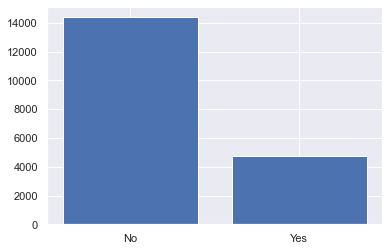

In [3]:
# Statistics on train data
sns.set()

df_train_viz = df_train.copy()
df_train_viz['target'] = df_train_viz['target'].apply(lambda x: 'Yes' if x==1 else 'No')
target_count = pd.DataFrame(df_train_viz['target'].value_counts())
fig, ax = plt.subplots()
plt.bar(target_count.index,target_count.target);

In [4]:
# Statistics on combined train and test data
pd.concat([df_train,df_test],axis=0).target.value_counts()

0    15934
1     5353
Name: target, dtype: int64

### 1. Examind data separability (before modeling)

In [5]:
# Use proper column names and Yes/No for viz
df_train['Experience (years)'] = df_train['experience'].replace(25,21)
df_train['Training Hours'] = df_train['training_hours']
df_train['New job?'] = df_train['target'].replace(0,'No').replace(1,'Yes')

In [6]:
# Set color palette
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

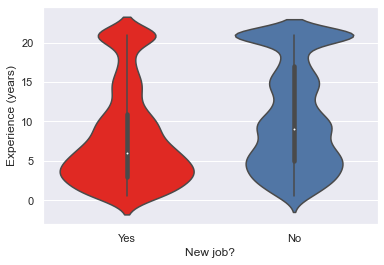

In [7]:
# Separability - violin plot
sns.violinplot(y =df_train['Experience (years)'],
              x=df_train['New job?'],);

In [8]:
# # Try out transparency
# sns.kdeplot(data=df_train, x="Experience (years)", hue="New job?", 
#             fill=True, common_norm=False,
#             alpha=.4, linewidth=0)

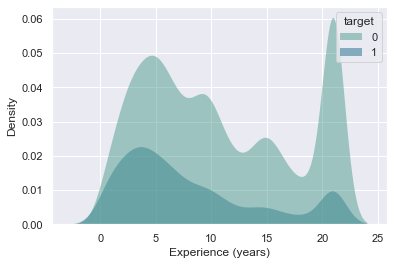

In [9]:
# Try out different color palette
sns.kdeplot(data=df_train, x="Experience (years)", hue="target",
            fill=True, common_norm=True, palette="crest",
            alpha=.5, linewidth=0);

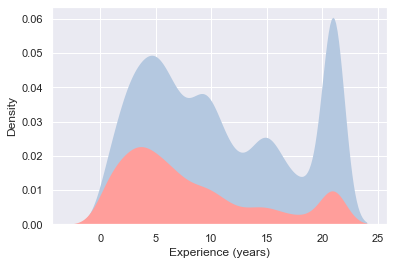

In [10]:
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
sns.set_palette(sns.color_palette(colors))

# kde plot for experience
fig,ax = plt.subplots()
sns.kdeplot(data=df_train, x="Experience (years)", hue="New job?",
            fill=True, common_norm=True, legend=False,
            alpha=1, linewidth=0)
fig.savefig('../plot/kde_experience.pdf', bbox_inches='tight', transparent=True)

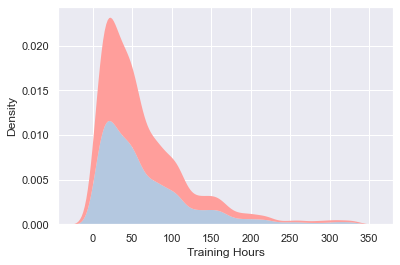

In [11]:
# kde plot for training hours
fig,ax = plt.subplots()
sns.set_palette(sns.color_palette(colors))
sns.kdeplot(data=df_train, x="Training Hours", hue="New job?", multiple="stack",
            fill=True, common_norm=False, legend=False,
            alpha=1, linewidth=0)
fig.savefig('../plot/kde_training_hours.pdf', bbox_inches='tight', transparent=True)

### 2. Modeling (Logistic Regression)

In [12]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)

In [13]:
y_scores = lm.predict_proba(X_test)
roc_df = pd.DataFrame(roc_curve(y_test, y_scores[:, 1])).transpose()
roc_df.columns=['fpr','tpr','threshold']
# roc_df.to_csv('../dump/roc_df_lr.csv')

In [14]:
# Combine test_df and probability from model prediction
df = df_test.copy()
prob_df = pd.DataFrame(lm.predict_proba(X_test)).apply(lambda x:round(x,3)*100)
df_all = pd.concat([df,prob_df],axis=1)

In [15]:
# Rename columns
df_all.columns = ['Candidate','city', 'city_development_index',
                  'Gender','relevent_experience','enrolled_university',
                  'Education',
                  'Major',
                  'Experience (years)',
                  'company_size',
                  'Current company',
                  'last_new_job',
                  'Training Hours',
                  'target',
                  'No_prob','Probability']
df_all['Candidate ID'] = df_all['Candidate']
df_all['New job?'] = df_all['target'].replace(0,'No').replace(1,'Yes')

### Visualization for streamlit

In [16]:
# altair visualization for streamlit

c = alt.Chart(df_all.iloc[:200]).mark_circle().encode(
    x=alt.X('Candidate',axis=alt.Axis(labels=False)), y='Training Hours',
    size='Probability', color='Current company',
    tooltip=['Probability', 'Candidate ID', 'Gender', 'Major', 'Education',
             'Training Hours', 'Experience (years)']).properties(width=700, height=200)
c

alt.Chart(...)

In [17]:
c = alt.Chart(df_all[df_all['Experience (years)']<21].iloc[:200]).\
    mark_circle(size=120).encode(
    x=alt.X('Experience (years)'), y='Training Hours', \
    color = alt.Color('New job?', scale=alt. 
                    Scale(domain=['Yes','No'], range=['#F4A0BE','steelblue'])),
    tooltip=['Probability', 'Candidate ID', 'Gender', 'Major', 'Education',
             'Training Hours', 'Experience (years)']).properties(width=400, height=200)
c

alt.Chart(...)

### Plotting probability vs number of candidates

In [18]:
# Load concise candidate and probability df
df = pd.read_csv('../dump/candidate_proba.csv')

In [19]:
# Define function to find the index of nearest value in an array for a given value
def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

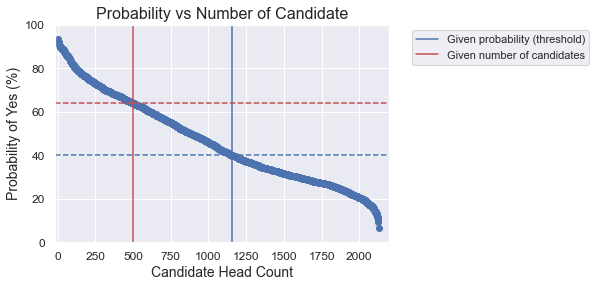

In [20]:
# Plot probability vs count of candidate
sns.set()

probability=40 #test value
i = find_nearest(df['Probability (%)'], probability)

fig, ax = plt.subplots()
plt.scatter(x=df.index, y=(df['Probability (%)']))

plt.axvline(x=i,label='Given probability (threshold)')
plt.axhline(y=probability,linestyle='--')

input_number_of_candidate=500
plt.axvline(x=input_number_of_candidate,color='r',label='Given number of candidates')
plt.axhline(y=df.iloc[input_number_of_candidate]['Probability (%)'],linestyle='--',color='r')

plt.legend(bbox_to_anchor=(1.05,1))
plt.xlim([-20,2200])
plt.ylim([0,100])
plt.ylabel('Probability of Yes (%)',fontsize=14)
plt.xlabel('Candidate Head Count',fontsize=14)
plt.title('Probability vs Number of Candidate',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

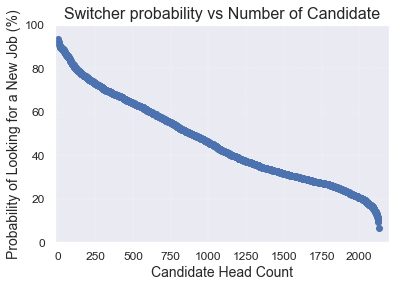

In [32]:
# Save figure without the guidence
fig, ax = plt.subplots()
plt.scatter(x=df.index, y=(df['Probability (%)']))
# plt.legend(bbox_to_anchor=(1.05,1))
plt.grid(linestyle='--', linewidth=.3)

plt.xlim([-20,2200])
plt.ylim([0,100])
plt.ylabel('Probability of Looking for a New Job (%)',fontsize=14)
plt.xlabel('Candidate Head Count',fontsize=14)
plt.title('Switcher probability vs Number of Candidate',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

fig.savefig('../plot/count_proba.pdf', bbox_inches='tight', transparent=True)